# Re-analysis to best align Acrydite-CTP-08 of brain

by Pu Zheng

2020.4.2

# 0. required packages for h5py

In [2]:
%run "..\Startup_py3.py"
sys.path.append(r"..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

87124


## 1. fov parameters

In [7]:
reload(classes.field_of_view)

before_fov_param = {'data_folder': r'\\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing',
                 #'save_folder':r'V:\20201221-Acr_ctp08_P_brain\Before_clearing\New',
                 'save_folder':r'\\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\Before_clearing\New', # use outside crick
                 'experiment_type': 'DNA',
                 'num_threads': 12,
                 'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
                 'shared_parameters':{
                         'single_im_size':[50,2048,2048],
                         'corr_channels':['750','647'],
                         'num_empty_frames': 0, 
                         'corr_hot_pixel':True,
                         'corr_Z_shift':False,
                         'min_num_seeds':500,
                         'max_num_seeds': 2500,
                         'spot_seeding_th':150,
                         'normalize_intensity_local':False,
                         'normalize_intensity_background':False,
                     },             
                 }

after_fov_param = {'data_folder': r'\\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\After_clearing',
                   #'save_folder':r'V:\20201221-Acr_ctp08_P_brain\After_clearing\New',
                   'save_folder':r'\\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\After_clearing\New', # use outside crick
                 'experiment_type': 'DNA',
                 'num_threads': 12,
                 'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
                 'shared_parameters':{
                         'single_im_size':[50,2048,2048],
                         'corr_channels':['750','647'],
                         'num_empty_frames': 0, 
                         'corr_hot_pixel':True,
                         'corr_Z_shift':False,
                         'min_num_seeds':500,
                         'max_num_seeds': 2500,
                         'spot_seeding_th':150,
                         'normalize_intensity_local':False,
                         'normalize_intensity_background':False,
                     },             
             }

#fov_ids = np.arange(5,11)
fov_ids = np.arange(5,6)

In [9]:
before_fovs = []

before_chrom_coords = []
before_fov_ids = []
before_cand_hzxys_list = []

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

# threshold intensity
intensity_th = 150 # lower limit of intensities
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.6 # 60% of regions should have candidate spots

for _fov_id in fov_ids:
    # create fov class
    before_fov = classes.field_of_view.Field_of_View(before_fov_param, _fov_id=_fov_id,
        _color_info_kwargs={
          '_color_filename':'Color_Usage',
        }, 
        _prioritize_saved_attrs=False,
        )
    # load DAPI image
    before_fov._load_dapi_image(_save=True)
    # load unique spots
    before_fov._load_from_file('unique')
    
    # assign spots to chromosomes
    _kept_chrom_coords = list(before_fov.chrom_coords.copy())
    _keep_chrom_flags = np.zeros(len(_kept_chrom_coords), dtype=np.bool)

    while not np.array(_keep_chrom_flags).all():
        # assign first
        _before_fov_cand_hzxys = [[] for _ct in _kept_chrom_coords]
        for _spots in before_fov.unique_spots_list:
            _kept_spots = _spots[_spots[:,0] > intensity_th]
            _cands_by_chr = assign_spots_to_chromosomes(_kept_spots, _kept_chrom_coords)
            for _i, _cands in enumerate(_cands_by_chr):
                if len(_cands) == 0:
                    _before_fov_cand_hzxys[_i].append([])
                else:
                    _hzxys = convert_spots_to_hzxys(_cands)
                    _chrom_hzxys = _kept_chrom_coords[_i] * np.array(before_fov.shared_parameters['distance_zxy'])
                    _dists = np.linalg.norm(np.array(_hzxys)[:,1:4] - _chrom_hzxys, axis=1)
                    _before_fov_cand_hzxys[_i].append(np.array(_hzxys)[(_dists < dist_th)])
        # check chromosome good percentage
        _keep_chrom_flags = []
        for _cid, _cands_list in enumerate(_before_fov_cand_hzxys):
            _good_percent = np.sum([len(_hzxys)>0 for _hzxys in _cands_list]) / len(_cands_list)
            _keep_chrom_flags.append(_good_percent >= good_chr_th)
        # update chromosomes
        _kept_chrom_coords = [_chrom for (_flg, _chrom) in zip(_keep_chrom_flags, _kept_chrom_coords) if _flg]

        print(f"- select {len(_kept_chrom_coords)} chromosomes from {len(_keep_chrom_flags)}")

    # collect final sets
    before_chrom_coords += _kept_chrom_coords
    before_cand_hzxys_list += _before_fov_cand_hzxys
    before_fov_ids += list(np.ones(len(_kept_chrom_coords),dtype=np.int)*before_fov.fov_id )
    # collect fov_classes
    before_fovs.append(before_fov)
    
    print(len(before_chrom_coords))
    
# summarize required variables
before_dna_reg_ids = before_fov.unique_ids
before_dna_reg_channels = before_fov.unique_channels


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 88
- Importing csv file: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 11 folders are found according to color-usage annotation.
+ loading fov_info from file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_05.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'dapi_im', 'ref_im'] in 11.497s.
+ loading correction from file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_05.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segme

E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


- select 117 chromosomes from 153
- select 117 chromosomes from 117
117


+ iter:0
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 3.491s
--- collapse all regions into 1d.


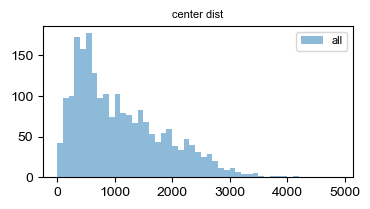

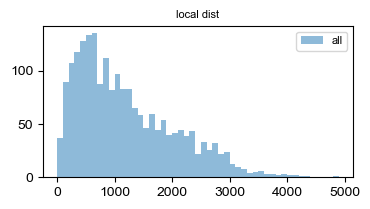

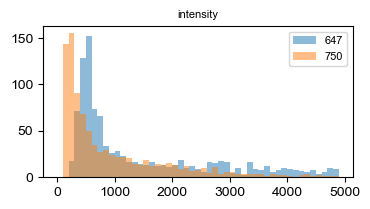

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.105s
-- region kept: 0.7374


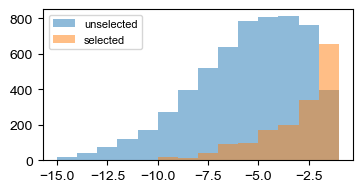

+ iter:1
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 4.748s
--- collapse all regions into 1d.


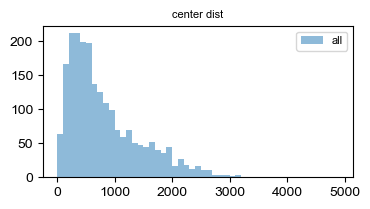

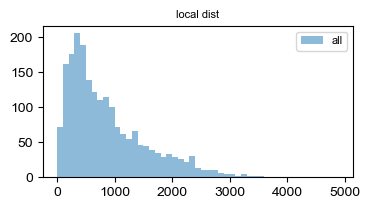

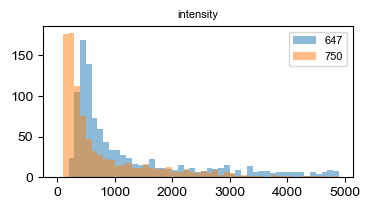

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.290s
-- region kept: 0.9050


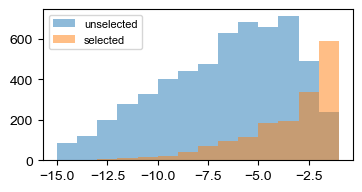

+ iter:2
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 4.280s
--- collapse all regions into 1d.


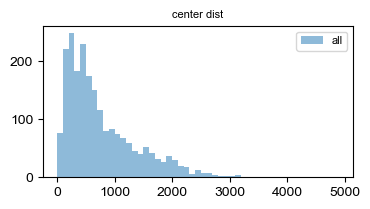

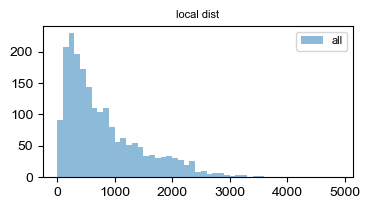

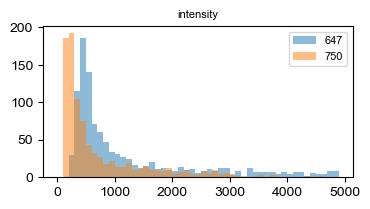

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.803s
-- region kept: 0.9643


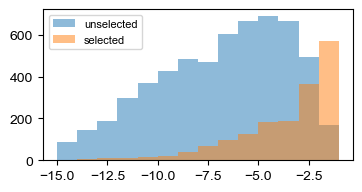

+ iter:3
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.325s
--- collapse all regions into 1d.


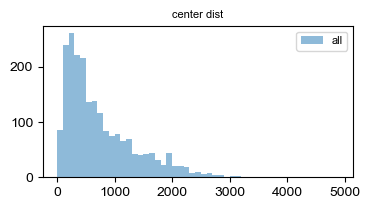

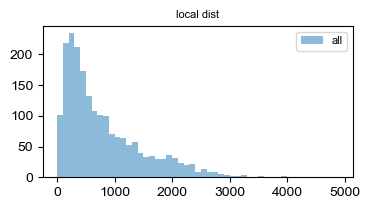

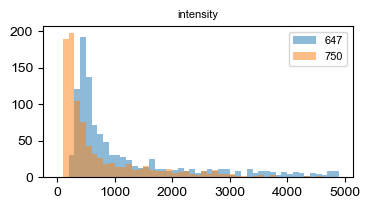

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.300s
-- region kept: 0.9861


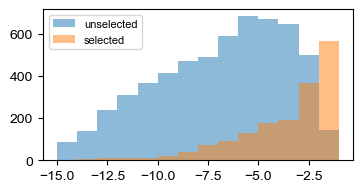

+ iter:4
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 4.424s
--- collapse all regions into 1d.


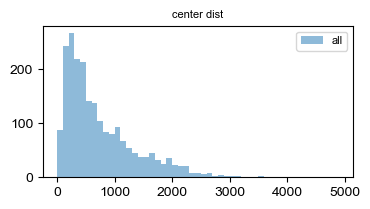

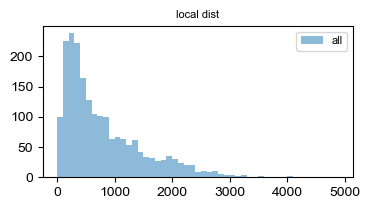

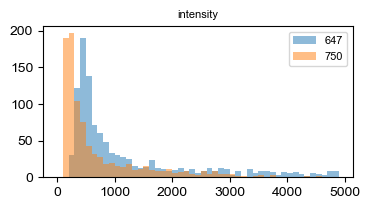

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.493s
-- region kept: 0.9954


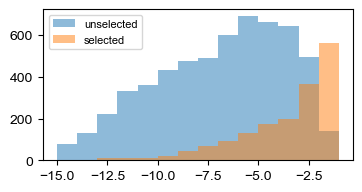

+ iter:5
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 4.538s
--- collapse all regions into 1d.


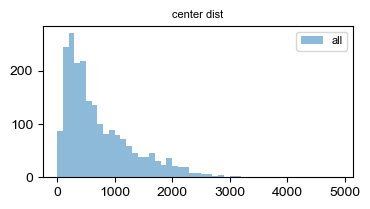

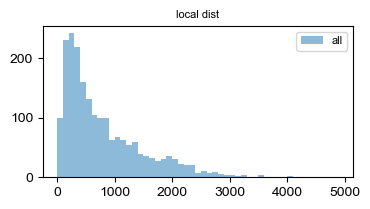

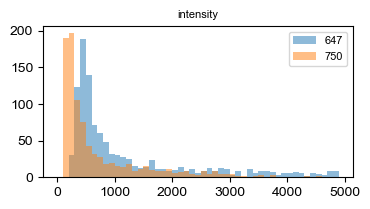

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.809s
-- region kept: 0.9972


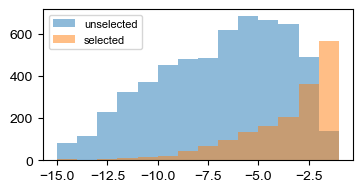

+ iter:6
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 4.413s
--- collapse all regions into 1d.


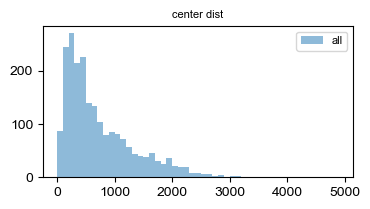

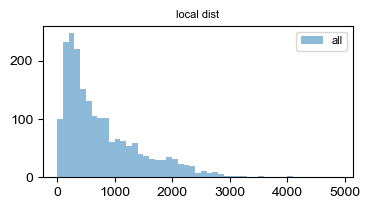

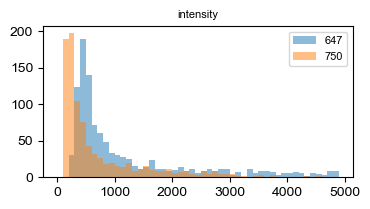

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.300s
-- region kept: 0.9977


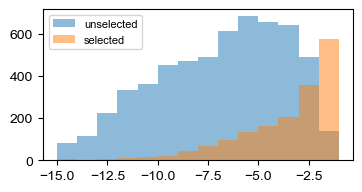

+ iter:7
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 3.890s
--- collapse all regions into 1d.


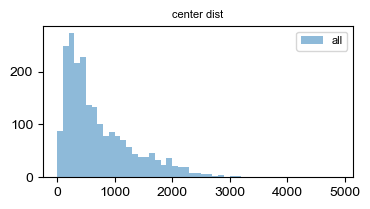

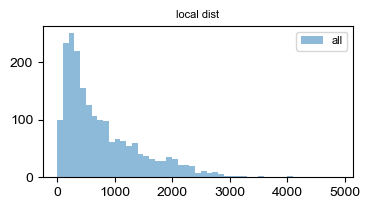

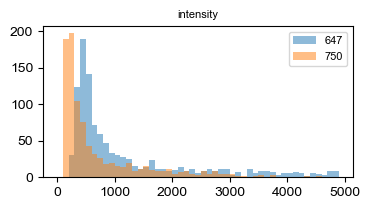

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 4.332s
-- region kept: 0.9986


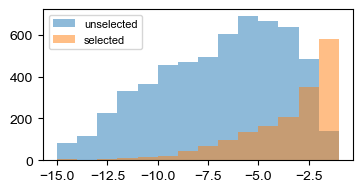

In [10]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 24
ref_chr_cts = None # whether use reference chromosome centers, default is No
# initialize
init_sel_hzxys = pick_spots_by_intensities(before_cand_hzxys_list)
# set save list
sel_hzxys_steps, sel_scores_steps, all_scores_steps, other_scores_steps = [init_sel_hzxys], [], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_hzxys_steps[-1], before_dna_reg_ids, 
        sel_hzxys_steps[-1], before_dna_reg_ids,
        ref_channels=before_dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    
    _sel_hzxys, _sel_scores, _all_scores, _other_scores = \
    pick_spots_by_scores(
        before_cand_hzxys_list, before_dna_reg_ids,
        cand_channels=before_dna_reg_channels, 
        ref_hzxys_list=sel_hzxys_steps[-1], ref_ids=before_dna_reg_ids, ref_channels=before_dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(_sel_hzxys, sel_hzxys_steps[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_hzxys_steps.append(_sel_hzxys)
    sel_scores_steps.append(_sel_scores)
    all_scores_steps.append(_all_scores)
    other_scores_steps.append(_other_scores)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in _other_scores]), 
             bins=np.arange(-15,0), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_scores)
                       for _scores in _sel_scores]), 
             bins=np.arange(-15,0), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

# collect final 
sel_iter = -1
before_sel_hzxys_list = sel_hzxys_steps[sel_iter]
before_sel_scores = sel_scores_steps[sel_iter]

## select threshold based on EM

In [29]:
from scipy.spatial.distance import pdist, squareform
before_final_hzxys_list = []
before_kept_chr_ids = []
before_distmap_list = []
score_th = -3.
int_th = 200
bad_spot_percentage = 1

for _hzxys, _scores in zip(before_sel_hzxys_list, before_sel_scores):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    _kept_hzxys[_scores < score_th] = np.nan
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0) < bad_spot_percentage:
        before_final_hzxys_list.append(_kept_hzxys)
        before_kept_chr_ids.append(True)
        before_distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        before_kept_chr_ids.append(False)

before_kept_chr_ids = np.array(before_kept_chr_ids, dtype=np.bool)
before_distmap_list = np.array(before_distmap_list)
before_median_distmap = np.nanmedian(before_distmap_list, axis=0)

0.39559202059202064


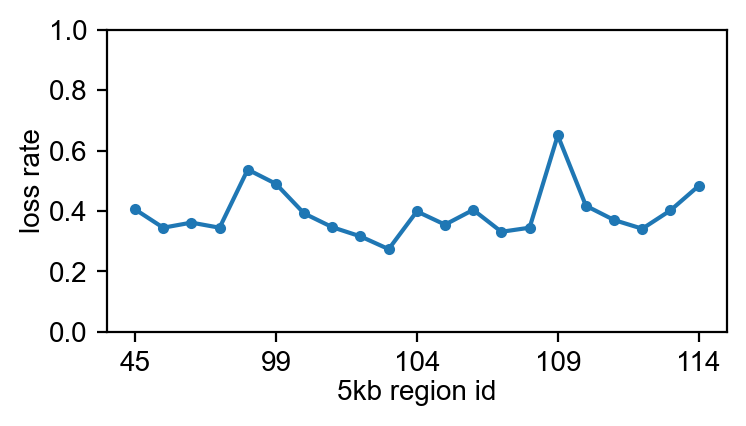

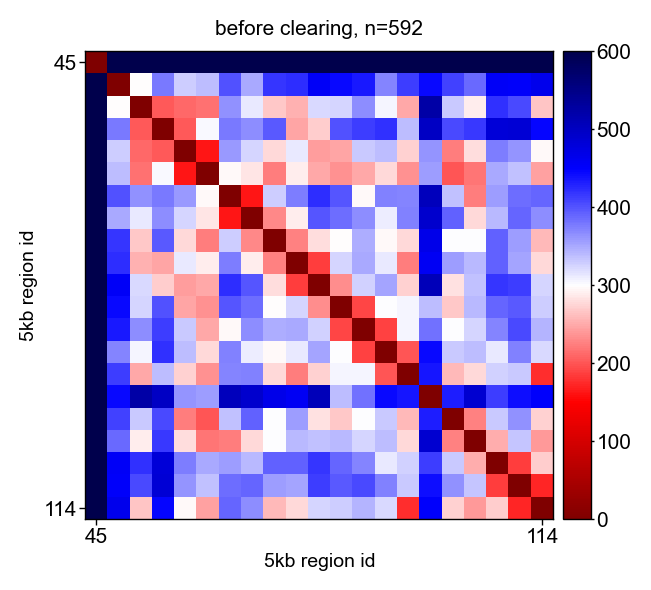

In [32]:
# generate plots
before_loss_rates = np.mean(np.sum(np.isnan(before_final_hzxys_list), axis=2)>0, axis=0)
print(np.mean(before_loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(before_loss_rates, '.-')
ax.set_ylim([0,1])
ax.set_ylabel(f"loss rate", labelpad=1)
ax.set_xlabel(f"5kb region id", labelpad=1)
ax.set_xticks(np.arange(0,len(before_dna_reg_ids),5))
ax.set_xticklabels(before_dna_reg_ids[np.arange(0,len(before_dna_reg_ids),5)])
plt.show()

imaging_order = []
for _fd, _infos in before_fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            if int(_info[1:]) in before_dna_reg_ids:
                imaging_order.append(list(before_dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
# choose one among these three
#kept_inds = imaging_order # plot imaging ordered regions
#kept_inds = np.where(loss_rates<0.5)[0] # plot good regions only
kept_inds = np.arange(len(before_dna_reg_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(before_median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"before clearing, n={len(before_distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(before_dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(before_dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [18]:
len(before_dna_reg_ids)

21

In [19]:
len(after_dna_reg_ids)

21

<IPython.core.display.Javascript object>


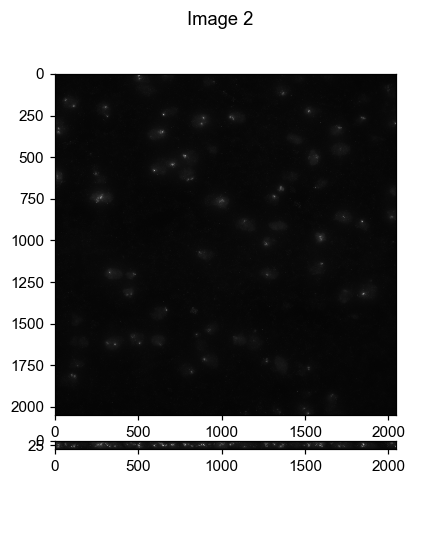

In [9]:
visual_tools.imshow_mark_3d_v2([before_fov.chrom_im, after_fov.chrom_im, ])

In [22]:
experiment_folder = r'\\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\For position align'
before_position_file = os.path.join(experiment_folder, '10x_positions.txt')
after_position_file = os.path.join(experiment_folder, '10x_positions_after.txt')
R, T = alignment_tools.align_manual_points(before_position_file, after_position_file, save=False)

- Manually picked points aligned, rotation:
[[ 0.9999884  -0.00481718]
 [ 0.00481718  0.9999884 ]],
 translation:[-314.50028637  184.9410772 ]


In [23]:
nim, rot, dft = correction_tools.alignment.calculate_translation(before_fov.dapi_im, 
                                                                 after_fov.dapi_im, np.transpose(R))



-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image


C:\Users\puzheng\Anaconda3\lib\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


--- drift: [  4.81  -0.17 -15.86] pixels


In [24]:
new_chrom_coords = spot_tools.translating.translate_spots(before_fov.chrom_coords, 
                                   rot, dft)

In [75]:
before_fov._load_reference_image(0)

+ load reference image from file:0
++ directly return existing attribute.


array([[[509, 540, 600, ..., 427, 533, 393],
        [539, 573, 566, ..., 459, 419, 428],
        [602, 581, 650, ..., 408, 434, 481],
        ...,
        [670, 686, 667, ..., 543, 514, 462],
        [700, 788, 748, ..., 521, 501, 428],
        [633, 738, 748, ..., 492, 426, 500]],

       [[570, 543, 531, ..., 430, 476, 428],
        [603, 635, 597, ..., 430, 421, 439],
        [575, 600, 667, ..., 456, 539, 498],
        ...,
        [627, 716, 725, ..., 394, 422, 489],
        [676, 713, 651, ..., 422, 409, 488],
        [620, 714, 742, ..., 460, 488, 409]],

       [[487, 581, 606, ..., 487, 482, 470],
        [549, 570, 596, ..., 447, 501, 430],
        [563, 572, 569, ..., 484, 502, 418],
        ...,
        [676, 719, 702, ..., 495, 475, 431],
        [636, 759, 714, ..., 455, 474, 432],
        [605, 615, 683, ..., 554, 428, 420]],

       ...,

       [[545, 692, 659, ..., 519, 458, 444],
        [626, 710, 671, ..., 487, 438, 465],
        [594, 683, 640, ..., 462, 481, 447

<IPython.core.display.Javascript object>


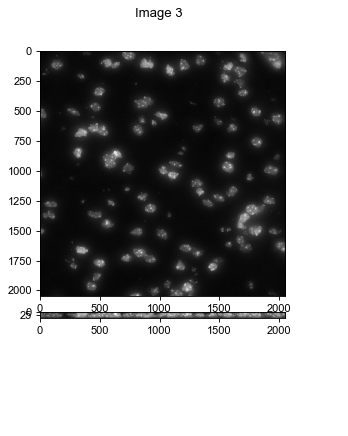

In [25]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([before_fov.dapi_im, after_fov.dapi_im, nim])

# after

In [14]:
after_fovs = []

after_chrom_coords = []
after_fov_ids = []
after_cand_hzxys_list = []

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

# threshold intensity
intensity_th = 200 # lower limit of intensities
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.6 # 60% of regions should have candidate spots

for _fov_id in fov_ids:
    # create fov class
    after_fov = classes.field_of_view.Field_of_View(after_fov_param, _fov_id=_fov_id,
        _color_info_kwargs={
          '_color_filename':'Color_Usage',
        }, 
        _prioritize_saved_attrs=True,
        )
    # load DAPI image
    after_fov._load_dapi_image(_save=True)
    # load unique spots
    after_fov._load_from_file('unique')
    
    # assign spots to chromosomes
    _kept_chrom_coords = list(after_fov.chrom_coords.copy())
    _keep_chrom_flags = np.zeros(len(_kept_chrom_coords), dtype=np.bool)

    while not np.array(_keep_chrom_flags).all():
        # assign first
        _after_fov_cand_hzxys = [[] for _ct in _kept_chrom_coords]
        for _spots in after_fov.unique_spots_list:
            _kept_spots = _spots[_spots[:,0] > intensity_th]
            _cands_by_chr = assign_spots_to_chromosomes(_kept_spots, _kept_chrom_coords)
            for _i, _cands in enumerate(_cands_by_chr):
                if len(_cands) == 0:
                    _after_fov_cand_hzxys[_i].append([])
                else:
                    _hzxys = convert_spots_to_hzxys(_cands)
                    _chrom_hzxys = _kept_chrom_coords[_i] * np.array(after_fov.shared_parameters['distance_zxy'])
                    _dists = np.linalg.norm(np.array(_hzxys)[:,1:4] - _chrom_hzxys, axis=1)
                    _after_fov_cand_hzxys[_i].append(np.array(_hzxys)[(_dists < dist_th)])
        # check chromosome good percentage
        _keep_chrom_flags = []
        for _cid, _cands_list in enumerate(_after_fov_cand_hzxys):
            _good_percent = np.sum([len(_hzxys)>0 for _hzxys in _cands_list]) / len(_cands_list)
            _keep_chrom_flags.append(_good_percent >= good_chr_th)
        # update chromosomes
        _kept_chrom_coords = [_chrom for (_flg, _chrom) in zip(_keep_chrom_flags, _kept_chrom_coords) if _flg]

        print(f"- select {len(_kept_chrom_coords)} chromosomes from {len(_keep_chrom_flags)}")

    # collect final sets
    after_chrom_coords += _kept_chrom_coords
    after_cand_hzxys_list += _after_fov_cand_hzxys
    after_fov_ids += list(np.ones(len(_kept_chrom_coords),dtype=np.int)*after_fov.fov_id )
    # collect fov_classes
    after_fovs.append(after_fov)
    
    print(len(after_chrom_coords))
    
# summarize required variables
after_dna_reg_ids = after_fov.unique_ids
after_dna_reg_channels = after_fov.unique_channels

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 88
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\After_clearing\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 11 folders are found according to color-usage annotation.
+ loading fov_info from file: V:\20201221-Acr_ctp08_P_brain\After_clearing\New\Conv_zscan_05.hdf5
color_dic
drift
rotation
shared_parameters
++ base attributes loaded:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'dapi_im', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'ref_im', 'rotation', 'save_filename', 'save_folder

++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: V:\20201221-Acr_ctp08_P_brain\After_clearing\New\Conv_zscan_08.hdf5
++ base attributes loaded:['segmentation_dim', 'segmentation_folder'] in 0.009s.
-- saving fov_info to file: V:\20201221-Acr_ctp08_P_brain\After_clearing\New\Conv_zscan_08.hdf5
++ base attributes saved:[] in 1.229s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\After_clearing\H0R0.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\After_clearing\H0R0\Conv_zscan_08.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_

+ iter:0
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.073s
--- collapse all regions into 1d.


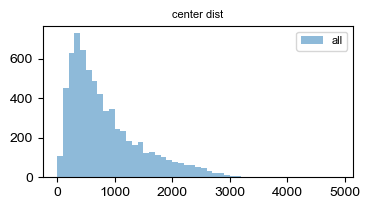

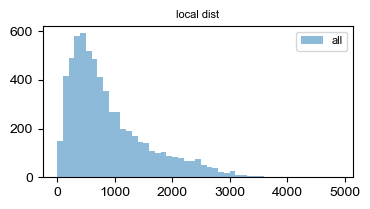

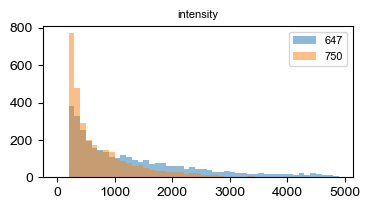

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.058s
-- region kept: 0.7954


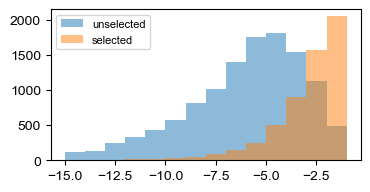

+ iter:1
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.051s
--- collapse all regions into 1d.


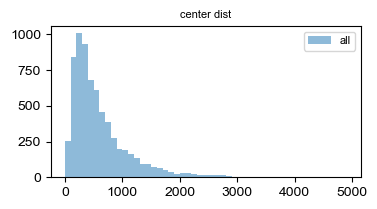

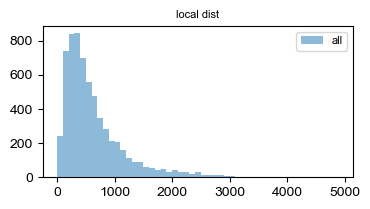

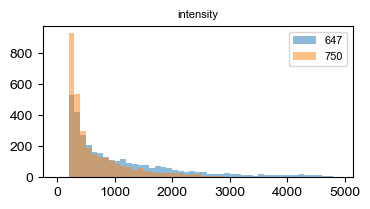

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.049s
-- region kept: 0.9356


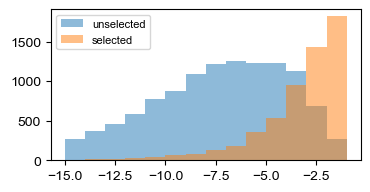

+ iter:2
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.060s
--- collapse all regions into 1d.


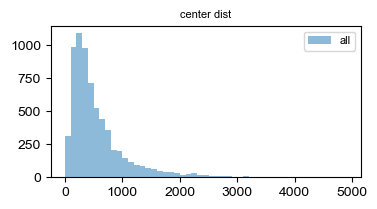

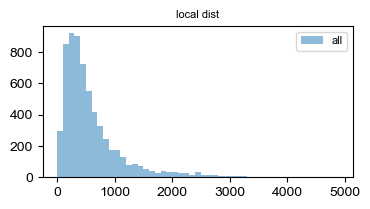

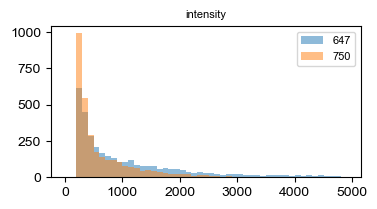

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.052s
-- region kept: 0.9804


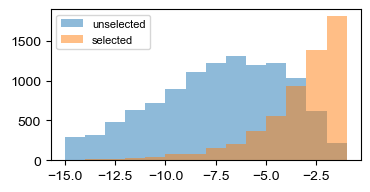

+ iter:3
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.038s
--- collapse all regions into 1d.


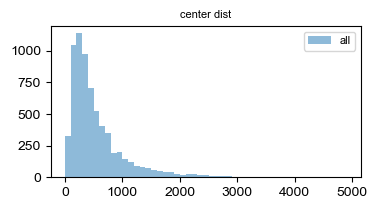

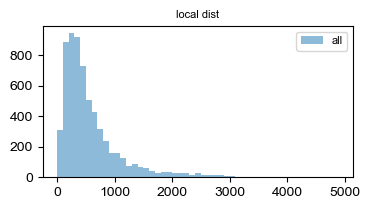

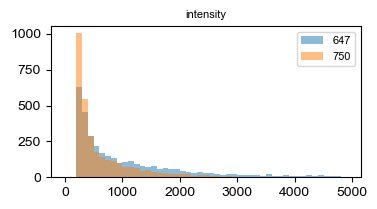

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.125s
-- region kept: 0.9924


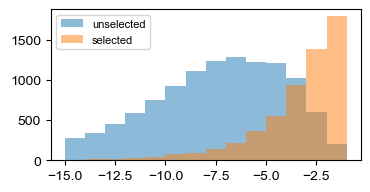

+ iter:4
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.160s
--- collapse all regions into 1d.


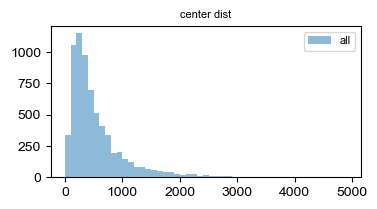

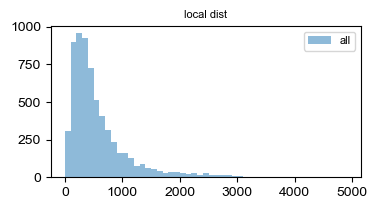

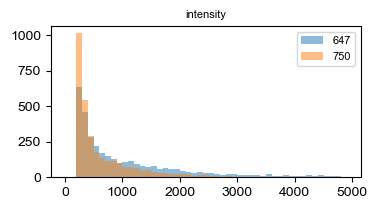

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.265s
-- region kept: 0.9955


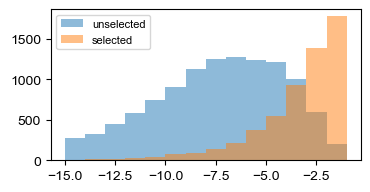

+ iter:5
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.067s
--- collapse all regions into 1d.


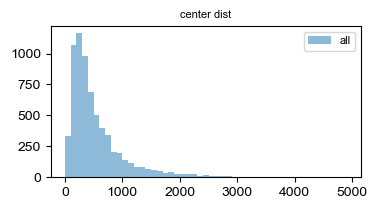

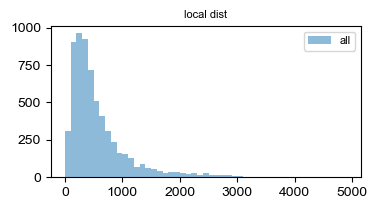

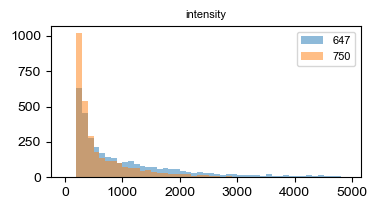

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.168s
-- region kept: 0.9976


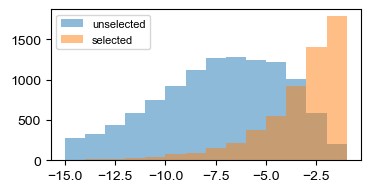

+ iter:6
-- generate reference metrics
--- multiprocessing expectation step with 24 threads, in 5.056s
--- collapse all regions into 1d.


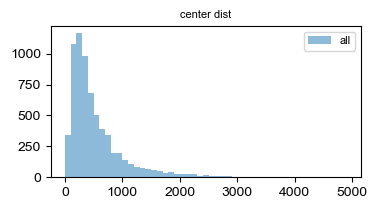

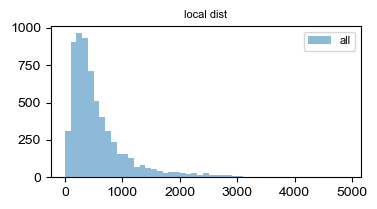

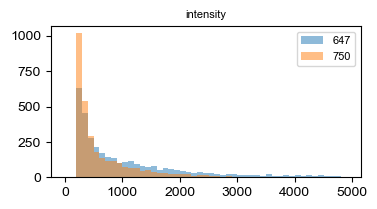

- pick spots by scores
--- multiprocessing maximization step with 24 threads, in 5.098s
-- region kept: 0.9987


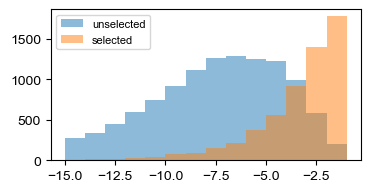

In [15]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 24
ref_chr_cts = None # whether use reference chromosome centers, default is No
# initialize
init_sel_hzxys = pick_spots_by_intensities(after_cand_hzxys_list)
# set save list
sel_hzxys_steps, sel_scores_steps, all_scores_steps, other_scores_steps = [init_sel_hzxys], [], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_hzxys_steps[-1], after_dna_reg_ids, 
        sel_hzxys_steps[-1], after_dna_reg_ids,
        ref_channels=after_dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    
    _sel_hzxys, _sel_scores, _all_scores, _other_scores = \
    pick_spots_by_scores(
        after_cand_hzxys_list, after_dna_reg_ids,
        cand_channels=after_dna_reg_channels, 
        ref_hzxys_list=sel_hzxys_steps[-1], ref_ids=after_dna_reg_ids, ref_channels=after_dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(_sel_hzxys, sel_hzxys_steps[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_hzxys_steps.append(_sel_hzxys)
    sel_scores_steps.append(_sel_scores)
    all_scores_steps.append(_all_scores)
    other_scores_steps.append(_other_scores)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in _other_scores]), 
             bins=np.arange(-15,0), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_scores)
                       for _scores in _sel_scores]), 
             bins=np.arange(-15,0), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

# collect final 
sel_iter = -1
after_sel_hzxys_list = sel_hzxys_steps[sel_iter]
after_sel_scores = sel_scores_steps[sel_iter]

In [16]:
from scipy.spatial.distance import pdist, squareform
after_final_hzxys_list = []
after_kept_chr_ids = []
after_distmap_list = []
score_th = -3.5
int_th = 200
bad_spot_percentage = 1

for _hzxys, _scores in zip(after_sel_hzxys_list, after_sel_scores):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    _kept_hzxys[_scores < score_th] = np.nan
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0) < bad_spot_percentage:
        after_final_hzxys_list.append(_kept_hzxys)
        after_kept_chr_ids.append(True)
        after_distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        after_kept_chr_ids.append(False)

after_kept_chr_ids = np.array(after_kept_chr_ids, dtype=np.bool)
after_distmap_list = np.array(after_distmap_list)
after_median_distmap = np.nanmedian(after_distmap_list, axis=0)

0.3875160875160874


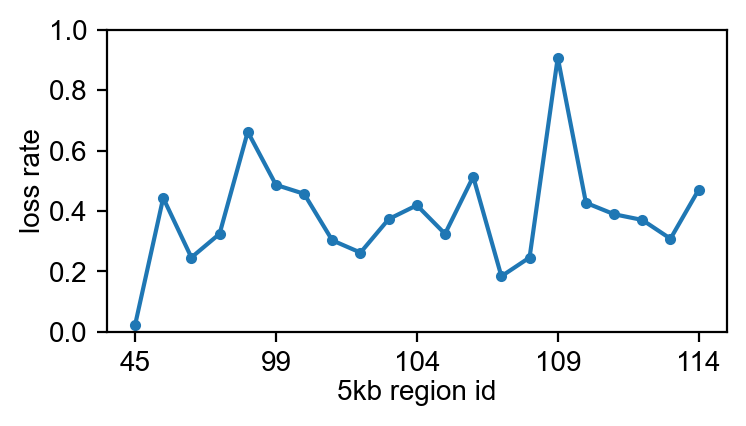

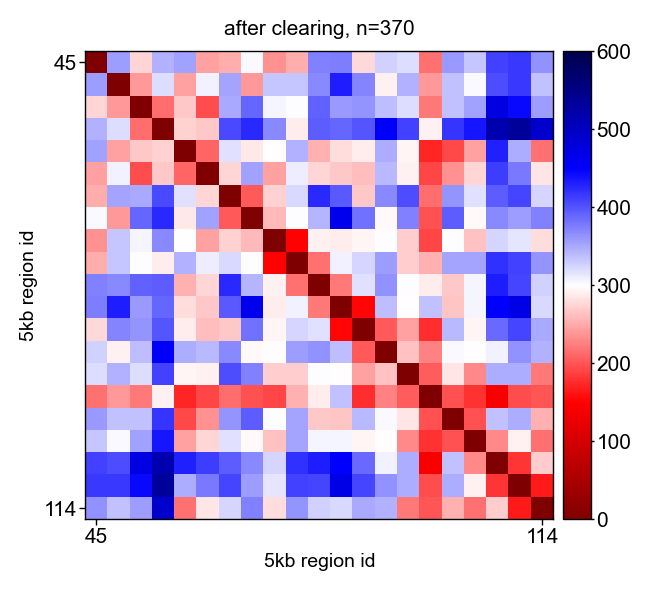

In [27]:
# generate plots
after_loss_rates = np.mean(np.sum(np.isnan(after_final_hzxys_list), axis=2)>0, axis=0)
print(np.mean(after_loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(after_loss_rates, '.-')
ax.set_ylim([0,1])
ax.set_ylabel(f"loss rate", labelpad=1)
ax.set_xlabel(f"5kb region id", labelpad=1)
ax.set_xticks(np.arange(0,len(after_dna_reg_ids),5))
ax.set_xticklabels(after_dna_reg_ids[np.arange(0,len(after_dna_reg_ids),5)])
plt.show()

imaging_order = []
for _fd, _infos in after_fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            if int(_info[1:]) in after_dna_reg_ids:
                imaging_order.append(list(after_dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
# choose one among these three
#kept_inds = imaging_order # plot imaging ordered regions
#kept_inds = np.where(loss_rates<0.5)[0] # plot good regions only
kept_inds = np.arange(len(after_dna_reg_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(after_median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"after clearing, n={len(after_distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(after_dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(after_dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [46]:
from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

In [48]:
# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((before_fov.dapi_im.mean(0), after_fov.dapi_im.mean(0)), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2049 is different from 3)

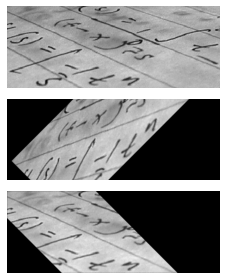

In [35]:
text = data.text()

tform = transform.SimilarityTransform(scale=1, rotation=math.pi/4,
                                      translation=(text.shape[0]/2, -100))

rotated = transform.warp(text, tform)
back_rotated = transform.warp(rotated, tform.inverse)

fig, ax = plt.subplots(nrows=3)

ax[0].imshow(text, cmap=plt.cm.gray)
ax[1].imshow(rotated, cmap=plt.cm.gray)
ax[2].imshow(back_rotated, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

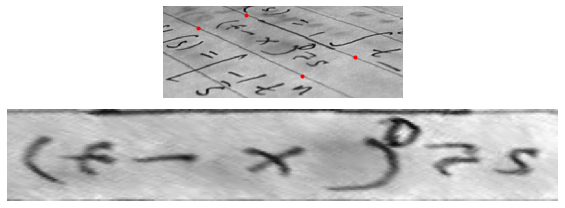

In [36]:
text = data.text()

src = np.array([[0, 0], [0, 50], [300, 50], [300, 0]])
dst = np.array([[155, 15], [65, 40], [260, 130], [360, 95]])

tform3 = transform.ProjectiveTransform()
tform3.estimate(src, dst)
warped = transform.warp(text, tform3, output_shape=(50, 300))

fig, ax = plt.subplots(nrows=2, figsize=(8, 3))

ax[0].imshow(text, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

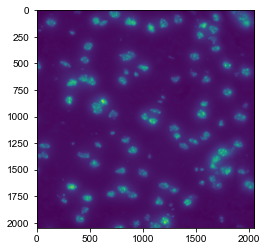

In [40]:
plt.figure()
plt.imshow(before_fov.dapi_im.max(0))

In [43]:
dapi_tform = transform.ProjectiveTransform()
dapi_tform.estimate(before_fov.dapi_im.max(0), after_fov.dapi_im.max(0))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2049 is different from 3)

In [44]:
after_fov.dapi_im.max(0).shape

(2048, 2048)

In [45]:
before_fov.dapi_im.max(0).shape

(2048, 2048)